In [3]:
import plenoptic as po
import torch
import numpy as np
# needed for the plotting/animating:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision

In [2]:
img = po.data.einstein(as_gray=False).to(0)

In [5]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /mnt/home/wbroderick/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


In [8]:
transform = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms()

In [9]:
class TorchVision(torch.nn.Module):
    def __init__(self, model, return_node: str, transform = None):
        super().__init__()
        self.transform = transform
        self.extractor = create_feature_extractor(model, return_nodes=[return_node])
        self.model = model
        self.return_node = return_node
    
    def forward(self, x):
        if self.transform is not None:
            x = self.transform(x)
        return self.extractor(x)[self.return_node]
    
    def plot_representation(
        self,
        data: torch.Tensor,
        ax = None,
        figsize = (15, 15),
        ylim = None,
        batch_idx = 0,
        title = None,
    ):
        # Select the batch index
        data = data[batch_idx]

        # Compute across channels spatal error
        spatial_error = torch.abs(data).mean(dim=0).detach().cpu().numpy()

        # Compute per-channel error
        error = torch.abs(data).mean(dim=(1, 2))  # Shape: (C,)
        sorted_idx = torch.argsort(error, descending=True)
        sorted_error = error[sorted_idx].detach().cpu().numpy()

        # Determine figure layout
        if ax is None:
            fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [1, 1]})
        else:
            ax = po.tools.clean_up_axes(ax, False, ["top", "right", "bottom", "left"], ["x", "y"])
            gs = ax.get_subplotspec().subgridspec(2, 1, height_ratios=[3, 1])
            fig = ax.figure
            axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

        # Plot average error across channels
        po.imshow(
            ax=axes[0], image=spatial_error[None, None, ...], title="Average Error Across Channels", vrange="auto0"
        )
        # axes[0].set_title()

        # Plot channel error distribution
        x_pos = np.arange(20)
        axes[1].bar(x_pos, sorted_error[:20], color="C1", alpha=0.7)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(sorted_idx[:20].tolist(), rotation=45)
        axes[1].set_xlabel("Channel")
        axes[1].set_ylabel("Absolute error")
        axes[1].set_title("Top 20 Channels Contributions to Error")

        if title is not None:
            fig.suptitle(title)

        return fig, axes

In [10]:
train_nodes, eval_nodes = get_graph_node_names(model)

In [11]:
eval_nodes[:20]

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu']

In [14]:
mdl = TorchVision(model, 'layer1.0.relu_2', transform)

In [17]:
mdl.to(0)
po.tools.remove_grad(mdl)
mdl.eval()
po.tools.validate.validate_model(mdl, device=0, image_shape=img.shape)

In [20]:
met = po.synth.Metamer(img, mdl)
met.synthesize(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

/mnt/home/wbroderick/plenoptic/src/plenoptic/synthesize/metamer.py:275: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/display.py:1024: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


(<Figure size 1700x500 with 5 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 4, 2],
  'misc': []})

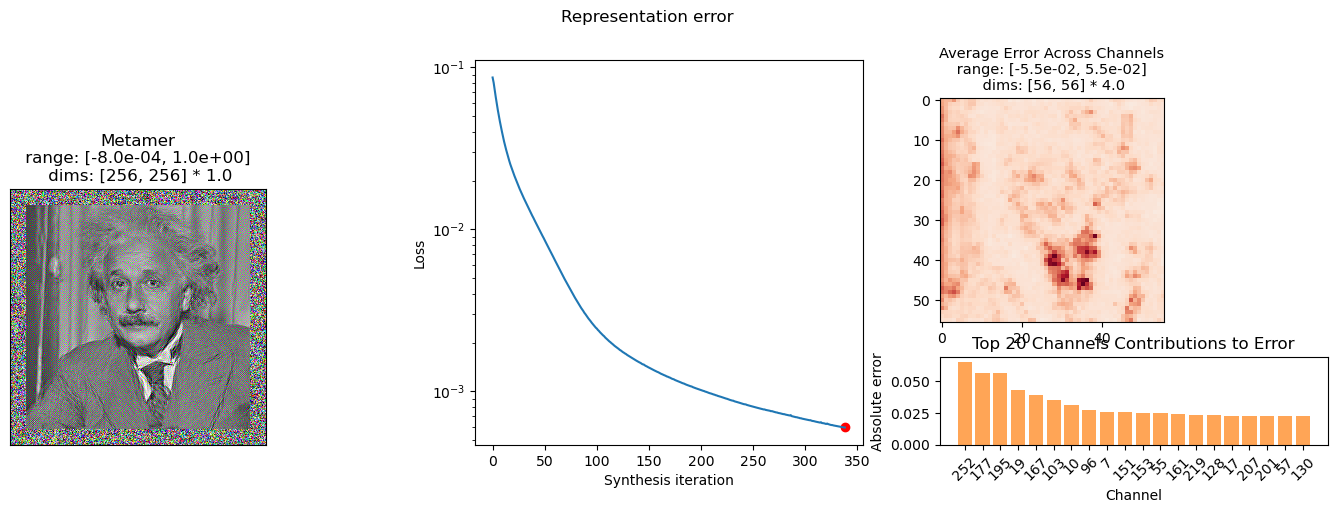

In [21]:
po.synth.metamer.plot_synthesis_status(met, ylim=False)